## Helper functions

In [1]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [2]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [3]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [4]:
def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [5]:
import yaml
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = 'None'
                data['average'] = 'None'
                lowest_obj.append('None')
                print("non_int data found... continue")
                print(data)

            scores_per_item.append(data)
            scores_with_indicator.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))

    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator

In [6]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue

    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [16]:
import yaml
def parse_data_test(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    scores_with_indicator = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue

        if flag == True:
            data = new_dict
            
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest_keys'] = lowest_keys
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                data['lowest'] = 'None'
                data['average'] = 'None'
                lowest_obj.append('None')
                print("non_int data found... continue")
                print(data)

            scores_per_item.append(data)
            scores_with_indicator.append((data,item['generated_cot'][0]['answers'][0]['correct_answer']))

    #filter for strings
    lowest_tuples = []
    for i in range(len(lowest_obj)):
        lowest_tuples.append((lowest_obj[i],scores_with_indicator[i][1]))
    print(lowest_tuples[0])
    filtered_lowest_tuples = [score_tuple for score_tuple in lowest_tuples if not any(isinstance(value, str) for value in score_tuple[0])]
         
    return scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator

In [7]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [8]:
def compare_true_false(obj_scores_true,obj_scores_false):

    averaged_true = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_true.items() if len([v for v in value if v is not None]) > 0}
    averaged_false = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in obj_scores_false.items() if len([v for v in value if v is not None]) > 0}


    # Convert the averaged data dictionary to a Pandas DataFrame
    df_true = pd.DataFrame.from_dict(averaged_true, orient='index', columns=['Average'])
    df_false = pd.DataFrame.from_dict(averaged_false, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df_true = df_true.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]
    df_false = df_false.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11','average']]

    # Rename the 'Average' column in each dataframe
    df_true.rename(columns={'Average': 'Average_true'}, inplace=True)
    df_false.rename(columns={'Average': 'Average_false'}, inplace=True)

    # Concatenate the dataframes horizontally along the columns
    merged_df = pd.concat([df_true, df_false], axis=1)

    merged_df['Difference'] = merged_df['Average_true'] - merged_df['Average_false']

  

    return merged_df

In [9]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


In [10]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [11]:
from scipy.stats import mannwhitneyu

def u_test(scores_with_indicator):

    #filter for strings
    filtered_scores_with_indicator = [score_tuple for score_tuple in scores_with_indicator if not any(isinstance(value, str) for value in score_tuple[0].values())]
    

    scores, indicators= zip(*filtered_scores_with_indicator)

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    print(dict_1.keys())

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

In [12]:
import copy
"""Only use if none ans should not be false"""
def generate_without_none_ans(data):
    all_data = copy.deepcopy(data)
    true_data = copy.deepcopy(data)
    false_data = copy.deepcopy(data)


    false_data.evaluate()
    false_data.select_generated_cots(answer=False)
    false_data = false_data.filter(lambda x: len(x["generated_cot"])==1)

    true_data.evaluate()
    true_data.select_generated_cots(answer=True)
    true_data = true_data.filter(lambda x: len(x["generated_cot"])==1)

    full_data = false_data.merge(true_data)

    ids = full_data.dump_ids()

    # print(len(ids))

    # print(all_data)

    none_data = all_data.filter(lambda ex: ex['id'] not in ids)

    # print(none_data)

    none_ids = none_data.dump_ids()

    return all_data.filter(lambda ex: ex['id'] not in none_ids)



In [14]:
import pandas as df
# Modify the function to handle 'None' as string
def handle_string(df, column):
    for index, value in df[column].items():
        if isinstance(value, str):
            if value.lower() == 'none':
                df.loc[index, column] = None  # or np.nan
            else:
                print(value)

# # Call the function
# handle_string(df, 'average')

# # Drop rows where 'Average' is None
# df = df[df['average'].notna()]

# # Make sure 'Average' column is of type float
# df['average'] = df['average'].astype(float)


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


## lowest test


In [28]:
import pandas as pd
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data_test(data,idx_cot=1,dataset='med_qa',split='test')


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 70, 'obj_6': 90, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100, 'lowest': 'None', 'average': 'None'}
(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], True)


In [19]:
scores_with_indicator[0]

({'obj_1': 100,
  'obj_2': 100,
  'obj_3': 100,
  'obj_4': 100,
  'obj_5': 100,
  'obj_6': 100,
  'obj_7': 100,
  'obj_8': 100,
  'obj_9': 100,
  'obj_10': 100,
  'obj_11': 100,
  'lowest_keys': ['obj_1',
   'obj_2',
   'obj_3',
   'obj_4',
   'obj_5',
   'obj_6',
   'obj_7',
   'obj_8',
   'obj_9',
   'obj_10',
   'obj_11'],
  'lowest': 100,
  'average': 100.0},
 True)

In [29]:
data = scores_with_indicator
data = [(t[0], False if t[1] is None else t[1]) for t in data]

df = pd.DataFrame([t[0] for t in data])
df['Indicator'] = [t[1] for t in data]

df_for_reg = copy.deepcopy(df)

In [21]:
df_for_reg

,obj_1,obj_2,obj_3,obj_4,obj_5,obj_6,obj_7,obj_8,obj_9,obj_10,obj_11,lowest_keys,lowest,average,Indicator
0,100,100,100,100,100,100,100,100,100,100,100,"[obj_1, obj_2, obj_3, obj_4, obj_5, obj_6, obj...",100,100.0,True
1,100,90,100,80,100,90,100,80,100,90,80,"[obj_4, obj_8, obj_11]",80,91.818182,False
2,100,100,100,100,100,100,100,90,100,100,50,[obj_11],50,94.545455,False
3,100,100,100,100,100,100,100,100,100,100,100,"[obj_1, obj_2, obj_3, obj_4, obj_5, obj_6, obj...",100,100.0,True
4,100,100,100,100,100,100,90,100,90,100,100,"[obj_7, obj_9]",90,98.181818,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,80,90,90,80,80,80,70,90,80,80,90,[obj_7],70,82.727273,True
496,100,100,100,90,100,90,100,100,80,100,100,[obj_9],80,96.363636,True
497,100,100,100,100,100,100,100,100,100,100,50,[obj_11],50,95.454545,True
498,80,100,90,90,80,80,90,90,70,80,100,[obj_9],70,86.363636,True


In [32]:
# Create a temporary dataframe for exploding 'lowest keys'
df_temp = df_for_reg['lowest_keys'].explode()

# Apply one-hot encoding
df_temp = pd.get_dummies(df_temp, prefix='lowest_keys')

# Aggregate the data back
df_temp = df_temp.groupby(df_temp.index).sum()

# Now join this back with the original dataframe
df_for_reg = df_for_reg.join(df_temp)

In [33]:
df_for_reg

,obj_1,obj_2,obj_3,obj_4,obj_5,obj_6,obj_7,obj_8,obj_9,obj_10,...,lowest_keys_obj_10,lowest_keys_obj_11,lowest_keys_obj_2,lowest_keys_obj_3,lowest_keys_obj_4,lowest_keys_obj_5,lowest_keys_obj_6,lowest_keys_obj_7,lowest_keys_obj_8,lowest_keys_obj_9
0,100,100,100,100,100,100,100,100,100,100,...,1,1,1,1,1,1,1,1,1,1
1,100,90,100,80,100,90,100,80,100,90,...,0,1,0,0,1,0,0,0,1,0
2,100,100,100,100,100,100,100,90,100,100,...,0,1,0,0,0,0,0,0,0,0
3,100,100,100,100,100,100,100,100,100,100,...,1,1,1,1,1,1,1,1,1,1
4,100,100,100,100,100,100,90,100,90,100,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,80,90,90,80,80,80,70,90,80,80,...,0,0,0,0,0,0,0,1,0,0
496,100,100,100,90,100,90,100,100,80,100,...,0,0,0,0,0,0,0,0,0,1
497,100,100,100,100,100,100,100,100,100,100,...,0,1,0,0,0,0,0,0,0,0
498,80,100,90,90,80,80,90,90,70,80,...,0,0,0,0,0,0,0,0,0,1


In [34]:
df_for_reg.columns

Index(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8',
       'obj_9', 'obj_10', 'obj_11', 'lowest_keys', 'lowest', 'average',
       'Indicator', 'lowest_keys_obj_1', 'lowest_keys_obj_10',
       'lowest_keys_obj_11', 'lowest_keys_obj_2', 'lowest_keys_obj_3',
       'lowest_keys_obj_4', 'lowest_keys_obj_5', 'lowest_keys_obj_6',
       'lowest_keys_obj_7', 'lowest_keys_obj_8', 'lowest_keys_obj_9'],
      dtype='object')

In [36]:
df_for_reg = df_for_reg.drop('lowest_keys', axis=1)


In [40]:
for column in df_for_reg.columns:
    if column.startswith('obj_'):
        is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
        df_for_reg = df_for_reg[is_float]

X = df_for_reg['average'].values.reshape(-1, 1)  # Features
y = df_for_reg['Indicator'].values  # Target variable




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [43]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# training accuracy:
classifier = LogisticRegression()
classifier.fit(X, y)

y_pred = classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Training Accuracy:", accuracy)

# Calculate the correlation matrix
correlation_matrix = df_for_reg.corr()

# Get the correlation values with the 'Indicator' variable
indicator_correlation = correlation_matrix['Indicator']

print(indicator_correlation)

Accuracy: 0.67
Training Accuracy: 0.687374749498998
obj_1                 0.234904
obj_2                 0.411084
obj_3                 0.122252
obj_4                 0.411661
obj_5                 0.262727
obj_6                 0.332656
obj_7                 0.330114
obj_8                 0.473946
obj_9                 0.194097
obj_10                0.376807
obj_11                0.370552
lowest                0.463773
average               0.412101
Indicator             1.000000
lowest_keys_obj_1     0.198740
lowest_keys_obj_10    0.159154
lowest_keys_obj_11   -0.149754
lowest_keys_obj_2     0.174114
lowest_keys_obj_3     0.198889
lowest_keys_obj_4     0.136747
lowest_keys_obj_5     0.185175
lowest_keys_obj_6     0.174613
lowest_keys_obj_7     0.337963
lowest_keys_obj_8     0.039616
lowest_keys_obj_9     0.381784
Name: Indicator, dtype: float64


In [ ]:
    
   
    handle_string(df,'average')
    #df = pd.DataFrame([(t[0]['average'], t[1]) for t in data], columns=['Average', 'Indicator'])

    df = df[df['average'].notna()]
    df = df.sort_values(by='average')

    df['Cumulative Count'] = df['Indicator'].cumsum()

    # Create a new column 'Cumulative Count False' that contains the cumulative count of 'False' values
    df['Cumulative Count False'] = (~df['Indicator']).cumsum()

    # Plot graph with 'Average' as x-axis and 'Cumulative Count' and 'Cumulative Count False' as y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(df['average'], df['Cumulative Count'], label='Correct')
    plt.plot(df['average'], df['Cumulative Count False'], label='Incorrect', color='red')
    plt.xlabel('Distribution of (in)correct answers when average objective score increases')
    plt.ylabel('Sum of questions evaluated')
    plt.title('Cumulative Count of True and False Values vs Average')
    plt.grid(True)
    plt.legend()
    plt.show()

    df['Difference'] = df['Cumulative Count False'] - df['Cumulative Count']

    # Find the maximum value in 'Difference'
    max_diff = df['Difference'].max()

    # Find the corresponding 'Cumulative Count True' and 'Cumulative Count False' values
    corresponding_values = df[df['Difference'] == max_diff][['Cumulative Count', 'Cumulative Count False']]

    print("Max Difference:", max_diff)
    print("Corresponding Values:")
    print(corresponding_values)

    #out of sample accuracy
    df_for_reg = df_for_reg[df_for_reg['average'].notna()]

    for column in df_for_reg.columns:
        if column.startswith('obj_'):
            is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
            df_for_reg = df_for_reg[is_float]

    X = df_for_reg['average'].values.reshape(-1, 1)  # Features
    y = df_for_reg['Indicator'].values  # Target variable




    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # training accuracy:
    classifier = LogisticRegression()
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Training Accuracy:", accuracy)

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Get the correlation values with the 'Indicator' variable
    indicator_correlation = correlation_matrix['Indicator']

    print(indicator_correlation)

## results indicative of correct answer

In [13]:
#GPT-3.5 supervised by GPT-4
import pandas as pd
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}

compare_true_false(scores_per_objective_true,scores_per_objective_false)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 70, 'obj_6': 90, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100, 'lowest': 'None', 'average': 'None'}
(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], True)
dict_keys(['obj_10', 'obj_2', 'obj_1', 'obj_5', 'obj_7', 'lowest', 'obj_4', 'obj_9', 'obj_8', 'obj_6', 'obj_11', 'average', 'obj_3'])
For obj_10, U-statistic is 43456.00 and the p-value is 0.00
For obj_2, U-statistic is 44535.00 and the p-value is 0.00
For obj_1, U-statistic is 38070.50 and the p-value is 0.00
For obj_5, U-statistic is 39848.50 and the p-value is 0.00
For obj_7, U-statistic is 41207.50 and the p-value is 0.00
For lowest, U-statistic is 47705.50 and the p-value is 0.00
For obj_4, U-statistic is 44340.50 and the p-value is 0.00
For obj_9, U-statistic is 35154.50 and the p-value is 0.00
For obj_8, U-statistic is 48081.00 and the p-value is 0.0

,Average_true,Average_false,Difference
obj_1,97.354949,93.737864,3.617085
obj_2,95.580205,85.412621,10.167583
obj_3,98.122867,95.946602,2.176265
obj_4,95.119454,83.737864,11.381590
obj_5,94.897611,88.640777,6.256834
obj_6,94.419795,86.043689,8.376106
obj_7,87.849829,78.446602,9.403227
obj_8,95.409556,80.097087,15.312469
obj_9,88.634812,82.572816,6.061997
obj_10,95.921502,86.674757,9.246744


## reproducible code

In [30]:
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')

(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], False)


In [45]:
def practical_results(scores_with_indicator):
    data = scores_with_indicator
    data = [(t[0], False if t[1] is None else t[1]) for t in data]

    #average only
    #df = pd.DataFrame([(t[0]['average'], t[1]) for t in data], columns=['average', 'Indicator'])

    #all objs
    df = pd.DataFrame([t[0] for t in data])
    df['Indicator'] = [t[1] for t in data]

    df_for_reg = copy.deepcopy(df)
    handle_string(df_for_reg,'average')
    handle_string(df,'average')
    #df = pd.DataFrame([(t[0]['average'], t[1]) for t in data], columns=['Average', 'Indicator'])

    df = df[df['average'].notna()]
    df = df.sort_values(by='average')

    df['Cumulative Count'] = df['Indicator'].cumsum()

    # Create a new column 'Cumulative Count False' that contains the cumulative count of 'False' values
    df['Cumulative Count False'] = (~df['Indicator']).cumsum()

    # Plot graph with 'Average' as x-axis and 'Cumulative Count' and 'Cumulative Count False' as y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(df['average'], df['Cumulative Count'], label='Correct')
    plt.plot(df['average'], df['Cumulative Count False'], label='Incorrect', color='red')
    plt.xlabel('Distribution of (in)correct answers when average objective score increases')
    plt.ylabel('Sum of questions evaluated')
    plt.title('Cumulative Count of True and False Values vs Average')
    plt.grid(True)
    plt.legend()
    plt.show()

    df['Difference'] = df['Cumulative Count False'] - df['Cumulative Count']

    # Find the maximum value in 'Difference'
    max_diff = df['Difference'].max()

    # Find the corresponding 'Cumulative Count True' and 'Cumulative Count False' values
    corresponding_values = df[df['Difference'] == max_diff][['Cumulative Count', 'Cumulative Count False']]

    print("Max Difference:", max_diff)
    print("Corresponding Values:")
    print(corresponding_values)

    #out of sample accuracy
    df_for_reg = df_for_reg[df_for_reg['average'].notna()]

    for column in df_for_reg.columns:
        if column.startswith('obj_'):
            is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
            df_for_reg = df_for_reg[is_float]

    X = df_for_reg['average'].values.reshape(-1, 1)  # Features
    y = df_for_reg['Indicator'].values  # Target variable




    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # training accuracy:
    classifier = LogisticRegression()
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Training Accuracy:", accuracy)

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Get the correlation values with the 'Indicator' variable
    indicator_correlation = correlation_matrix['Indicator']

    print(indicator_correlation)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
non_int data found... continue
{'obj_1': '100%', 'obj_2': '100%', 'obj_3': '100%', 'obj_4': '90%', 'obj_5': '90%', 'obj_6': '90%', 'obj_7': '80%', 'obj_8': '90%', 'obj_9': '80%', 'obj_10': '90%', 'obj_11': '100%', 'lowest': 'None', 'average': 'None'}
(['obj_4'], True)


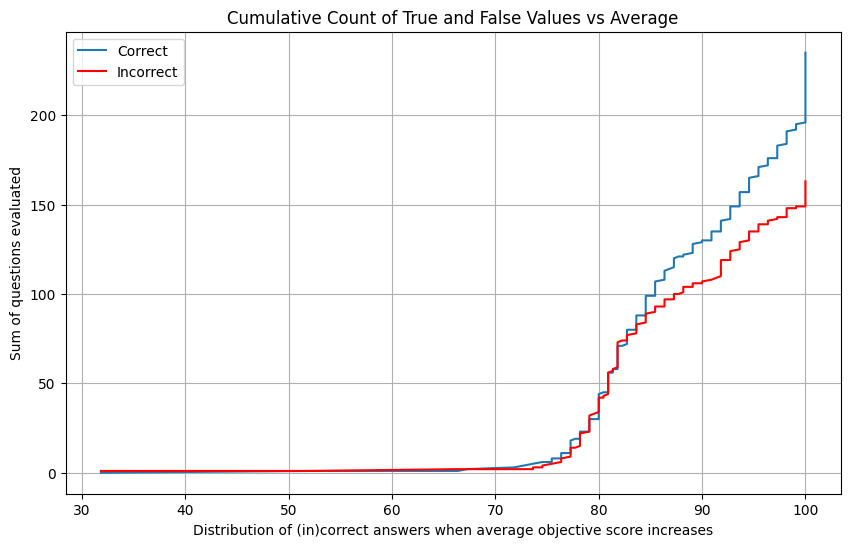

Max Difference: 4
Corresponding Values:
     Cumulative Count  Cumulative Count False
363                25                      29
209                30                      34
169                63                      67
Accuracy: 0.5875
Training Accuracy: 0.5829145728643216
obj_1                     0.117501
obj_2                     0.093427
obj_3                     0.111022
obj_4                     0.167537
obj_5                     0.113342
obj_6                     0.121151
obj_7                     0.113241
obj_8                     0.135372
obj_9                     0.099160
obj_10                    0.136002
obj_11                    0.166411
lowest                    0.142334
average                   0.143391
Indicator                 1.000000
Cumulative Count          0.160791
Cumulative Count False    0.145938
Difference               -0.182317
Name: Indicator, dtype: float64


In [46]:
# GPT-3.5 supervised by GPT-3.5
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 100, 'obj_6': 100, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100, 'lowest': 'None', 'average': 'None'}
non_int data found... continue
{'obj_1': 'The reasoning accurately breaks down the question into smaller parts and analyzes each possible outcome.', 'obj_2': 'The reasoning considers all relevant information and does not consider irrelevant information.', 'obj_3': 'The reasoning accurately interprets and incorporates the numerical information provided by the user.', 'obj_4': 'The reasoning considers all relevant reasoning strategies and selects the most appropriate reasoning strategy, but could benefit from more detailed explanations of the biochemical processes involved.', 'obj_5': 'The reasoning is structured through reasoning steps, but could benefit from more sub-questions to further break down the analysis.', 'obj_6': 'The reasoning gives appropriate priorit

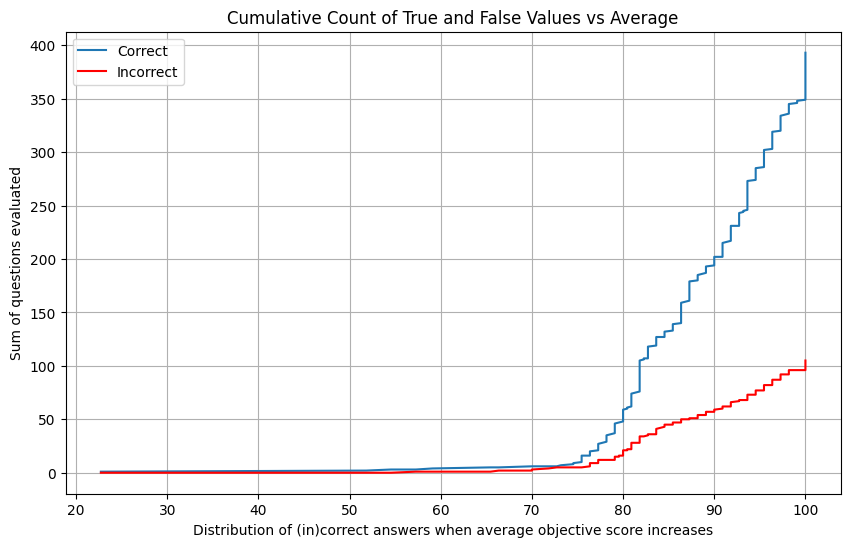

Max Difference: -1
Corresponding Values:
     Cumulative Count  Cumulative Count False
167                 1                       0
80                  6                       5
Accuracy: 0.78
Training Accuracy: 0.7891566265060241
obj_1                     0.011184
obj_2                     0.082436
obj_3                     0.092901
obj_4                     0.064687
obj_5                    -0.016971
obj_6                     0.052358
obj_7                     0.042715
obj_8                     0.053883
obj_9                     0.030980
obj_10                    0.040621
obj_11                    0.045854
lowest                    0.024303
average                   0.048616
Indicator                 1.000000
Cumulative Count          0.051581
Cumulative Count False    0.045239
Difference               -0.053667
Name: Indicator, dtype: float64


In [47]:
# GPT-4 supervised by GPT-3.5
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_100_first_gpt-4_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], False)


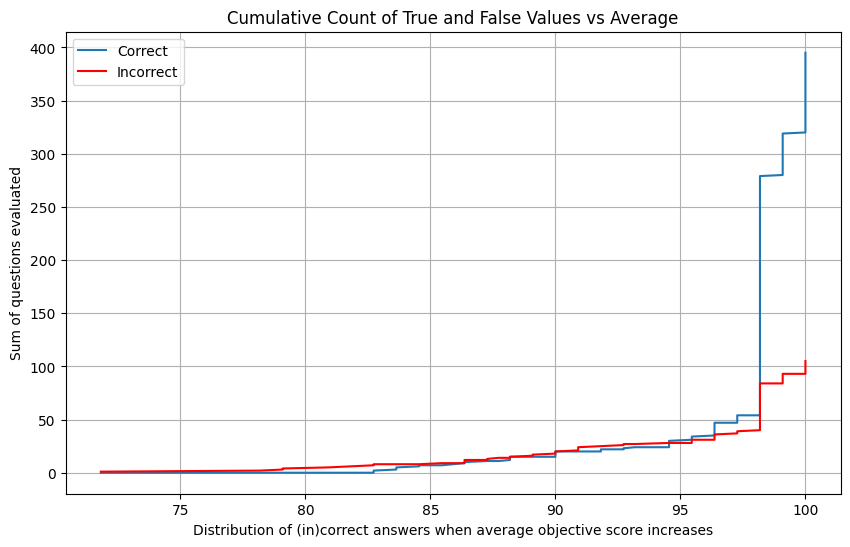

Max Difference: 8
Corresponding Values:
     Cumulative Count  Cumulative Count False
148                 0                       8
Accuracy: 0.78
Training Accuracy: 0.794
obj_1                     0.171472
obj_2                     0.238102
obj_3                     0.067392
obj_4                     0.244681
obj_5                     0.121717
obj_6                     0.241012
obj_7                     0.204262
obj_8                     0.264401
obj_9                     0.025495
obj_10                    0.206819
obj_11                    0.209433
lowest                    0.263987
average                   0.274466
Indicator                 1.000000
Cumulative Count          0.193491
Cumulative Count False    0.219420
Difference               -0.184489
Name: Indicator, dtype: float64


In [48]:
# GPT-4 supervised by GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue
{'obj_1': 100, 'obj_2': 100, 'obj_3': 'N/A', 'obj_4': 100, 'obj_5': 70, 'obj_6': 90, 'obj_7': 100, 'obj_8': 100, 'obj_9': 100, 'obj_10': 100, 'obj_11': 100, 'lowest': 'None', 'average': 'None'}
(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], True)


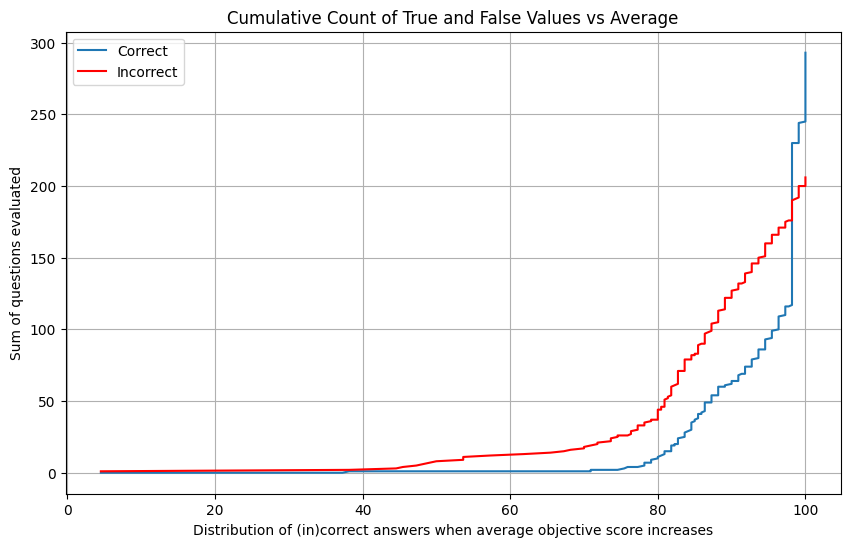

Max Difference: 69
Corresponding Values:
     Cumulative Count  Cumulative Count False
373                75                     144
451               100                     169
12                102                     171
Accuracy: 0.68
Training Accuracy: 0.687374749498998
obj_1                     0.234904
obj_2                     0.411084
obj_3                     0.122252
obj_4                     0.411661
obj_5                     0.262727
obj_6                     0.332656
obj_7                     0.330114
obj_8                     0.473946
obj_9                     0.194097
obj_10                    0.376807
obj_11                    0.370552
lowest                    0.463773
average                   0.412101
Indicator                 1.000000
Cumulative Count          0.444381
Cumulative Count False    0.451423
Difference               -0.278741
Name: Indicator, dtype: float64


In [49]:
#GPT-3.5 supervised by GPT-4
import pandas as pd
data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

non_int data found... continue
{'obj_1': 'The reasoning accurately identifies that the patient has had a stroke, but does not provide a detailed breakdown of the question.', 'obj_2': 'The reasoning considers the relevant information and does not include irrelevant information.', 'obj_3': "The reasoning does not incorporate the numerical information provided by the user, such as the patient's blood pressure and pulse rate.", 'obj_4': 'The reasoning only considers one reasoning strategy, which is the most common cause of a stroke, but does not consider other possible causes or differential diagnoses.', 'obj_5': 'The reasoning is not structured and lacks detail, such as sub-questions or reasoning steps.', 'obj_6': 'The reasoning does not give appropriate priorities to different considerations based on their relevance and importance.', 'obj_7': 'The reasoning does not list or consider all relevant underlying assumptions.', 'obj_8': 'The reasoning is plausible and coherent, but lacks import

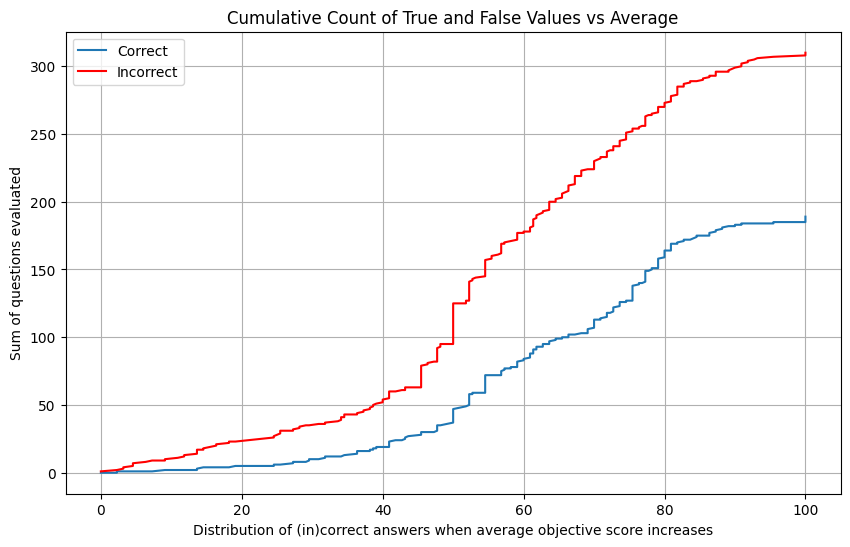

Max Difference: 125
Corresponding Values:
     Cumulative Count  Cumulative Count False
492               126                     251
471               127                     252
Accuracy: 0.59
Training Accuracy: 0.6132264529058116
obj_1                     0.126373
obj_2                     0.117741
obj_3                     0.136856
obj_4                     0.155557
obj_5                     0.113137
obj_6                     0.161567
obj_7                     0.116791
obj_8                     0.169337
obj_9                     0.145016
obj_10                    0.168426
obj_11                    0.146365
lowest                    0.155997
average                   0.160982
Indicator                 1.000000
Cumulative Count          0.157658
Cumulative Count False    0.154984
Difference                0.141780
Name: Indicator, dtype: float64


In [52]:
#Cohere supervised by GPT-3.5-turbo

data = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

(['obj_9'], True)


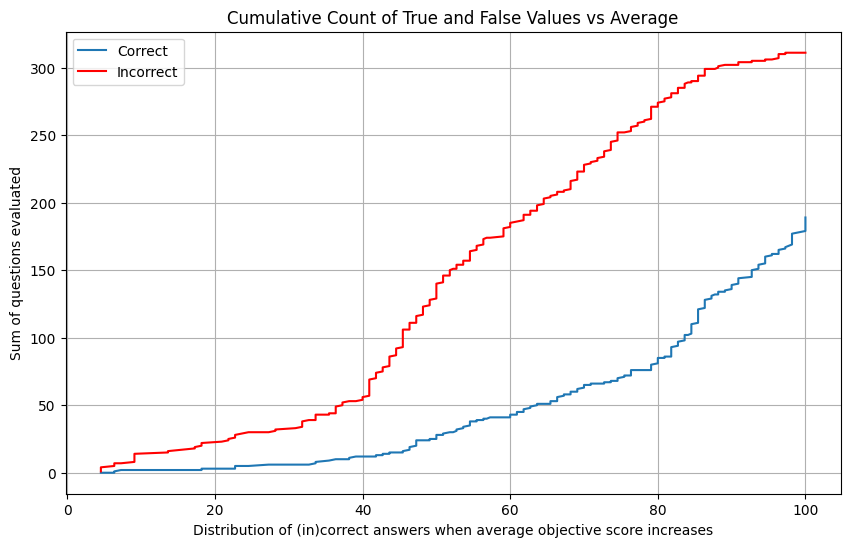

Max Difference: 194
Corresponding Values:
     Cumulative Count  Cumulative Count False
461                86                     280
Accuracy: 0.68
Training Accuracy: 0.738
obj_1                     0.208893
obj_2                     0.385459
obj_3                     0.143985
obj_4                     0.422895
obj_5                     0.272391
obj_6                     0.398196
obj_7                     0.329369
obj_8                     0.479714
obj_9                     0.348137
obj_10                    0.398248
obj_11                    0.412624
lowest                    0.456141
average                   0.430658
Indicator                 1.000000
Cumulative Count          0.491517
Cumulative Count False    0.422128
Difference                0.287405
Name: Indicator, dtype: float64


In [53]:
#Cohere supervised by GPT-4

data = Collection.from_json("./med_qa_first_cohere_gpt-4.json")
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
practical_results(scores_with_indicator)

In [ ]:
practical_results(scores_with_indicator)

## Practice

In [16]:
data = scores_with_indicator
data = [(t[0], False if t[1] is None else t[1]) for t in data]

#average only
df = pd.DataFrame([(t[0]['average'], t[1]) for t in data], columns=['average', 'Indicator'])

#all objs
# df = pd.DataFrame([t[0] for t in data])
# df['Indicator'] = [t[1] for t in data]

df_for_reg = copy.deepcopy(df)
handle_string(df_for_reg,'average')
handle_string(df,'average')
#df = pd.DataFrame([(t[0]['average'], t[1]) for t in data], columns=['Average', 'Indicator'])


In [17]:
df = df[df['average'].notna()]
df = df.sort_values(by='average')
df

,average,Indicator
99,4.545455,False
35,37.272727,False
80,38.181818,True
285,44.545455,False
391,45.454545,False
...,...,...
148,100.0,True
401,100.0,True
151,100.0,True
167,100.0,True


In [18]:
df['Cumulative Count'] = df['Indicator'].cumsum()

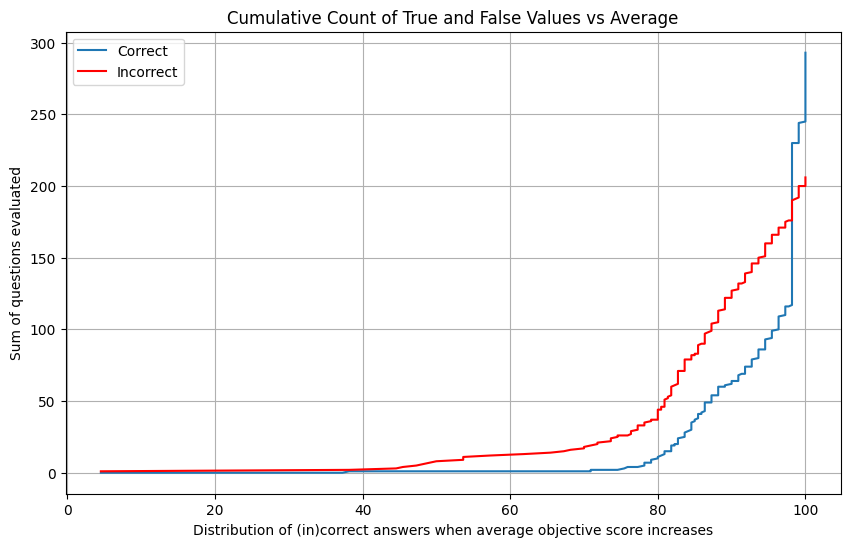

In [24]:
# Create a new column 'Cumulative Count False' that contains the cumulative count of 'False' values
df['Cumulative Count False'] = (~df['Indicator']).cumsum()

# Plot graph with 'Average' as x-axis and 'Cumulative Count' and 'Cumulative Count False' as y-axis
plt.figure(figsize=(10, 6))
plt.plot(df['average'], df['Cumulative Count'], label='Correct')
plt.plot(df['average'], df['Cumulative Count False'], label='Incorrect', color='red')
plt.xlabel('Distribution of (in)correct answers when average objective score increases')
plt.ylabel('Sum of questions evaluated')
plt.title('Cumulative Count of True and False Values vs Average')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
df['Difference'] = df['Cumulative Count'] - df['Cumulative Count False']

# Find the maximum value in 'Difference'
max_diff = df['Difference'].max()

# Find the corresponding 'Cumulative Count True' and 'Cumulative Count False' values
corresponding_values = df[df['Difference'] == max_diff][['Cumulative Count', 'Cumulative Count False']]

print("Max Difference:", max_diff)
print("Corresponding Values:")
print(corresponding_values)

#naively switching predictions would yield a 17.4% accuracy increase


Max Difference: 87
Corresponding Values:
   Cumulative Count  Cumulative Count False
0               293                     206


## Log regression


In [122]:
df_for_reg

,average,Indicator
0,100.0,True
1,91.818182,False
2,94.545455,False
3,100.0,True
4,98.181818,True
...,...,...
495,82.727273,True
496,96.363636,True
497,95.454545,True
498,86.363636,True


In [125]:
df_for_reg = df_for_reg[df_for_reg['average'].notna()]

X = df_for_reg['average'].values.reshape(-1, 1)  # Features
y = df_for_reg['Indicator'].values  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.68


In [126]:
classifier = LogisticRegression()
classifier.fit(X, y)

y_pred = classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.687374749498998


## Logistic regression with all obj

In [127]:

data = scores_with_indicator
data = [(t[0], False if t[1] is None else t[1]) for t in data]
df = pd.DataFrame([t[0] for t in data])
df['Indicator'] = [t[1] for t in data]

# Transform list of tuples into a DataFrame
df = pd.DataFrame([t[0] for t in data])
df['Indicator'] = [t[1] for t in data]

df_for_reg = copy.deepcopy(df)

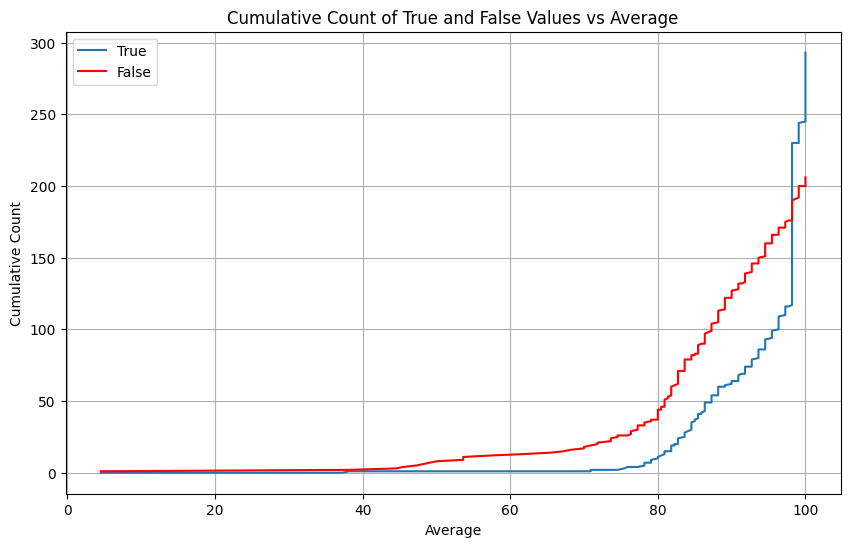

In [129]:
# Sort DataFrame based on the 'Average' column from low to high
df = df.sort_values(by='average')

# Create new columns 'Cumulative Count True' and 'Cumulative Count False' 
# that contain the cumulative counts of 'True' and 'False' values, respectively
df['Cumulative Count True'] = (df['Indicator'] == True).cumsum()
df['Cumulative Count False'] = (df['Indicator'] == False).cumsum()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['average'], df['Cumulative Count True'], label='True')
plt.plot(df['average'], df['Cumulative Count False'], label='False', color='r')
plt.xlabel('Average')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Count of True and False Values vs Average')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# calculate biggest distance between cumsums and give a guess rate

In [130]:
for column in df_for_reg.columns:
    if column.startswith('obj_'):
        is_float = df_for_reg[column].apply(lambda x: not isinstance(x, str))
        df_for_reg = df_for_reg[is_float]

In [102]:
df_for_reg

,obj_1,obj_2,obj_3,obj_4,obj_5,obj_6,obj_7,obj_8,obj_9,obj_10,obj_11,lowest,average,Indicator
0,100,100,100,100,100,100,100,100,100,100,100,100,100.0,True
1,100,90,100,80,100,90,100,80,100,90,80,80,91.818182,False
2,100,100,100,100,100,100,100,90,100,100,50,50,94.545455,False
3,100,100,100,100,100,100,100,100,100,100,100,100,100.0,True
4,100,100,100,100,100,100,90,100,90,100,100,90,98.181818,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,80,90,90,80,80,80,70,90,80,80,90,70,82.727273,True
496,100,100,100,90,100,90,100,100,80,100,100,80,96.363636,True
497,100,100,100,100,100,100,100,100,100,100,50,50,95.454545,True
498,80,100,90,90,80,80,90,90,70,80,100,70,86.363636,True


In [149]:
X = df_for_reg.drop('Indicator', axis=1)  # Features
y = df_for_reg['Indicator']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.77


In [151]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X, y)

y_pred = classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.7715430861723447


## GPT-4 itself

In [25]:
# GPT-4 supervised by GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
scores_per_item, variables_per_item, filtered_lowest_tuples, scores_with_indicator = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
scores_per_objective_true,scores_per_objective_false = u_test(scores_with_indicator)
range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}

compare_true_false(scores_per_objective_true,scores_per_objective_false)

(['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11'], False)
dict_keys(['obj_10', 'obj_2', 'obj_1', 'obj_5', 'obj_7', 'lowest', 'obj_4', 'obj_9', 'obj_8', 'obj_6', 'obj_11', 'average', 'obj_3'])
For obj_10, U-statistic is 23527.50 and the p-value is 0.00
For obj_2, U-statistic is 24847.50 and the p-value is 0.00
For obj_1, U-statistic is 22583.00 and the p-value is 0.00
For obj_5, U-statistic is 22624.50 and the p-value is 0.00
For obj_7, U-statistic is 25066.50 and the p-value is 0.00
For lowest, U-statistic is 25841.50 and the p-value is 0.00
For obj_4, U-statistic is 24507.50 and the p-value is 0.00
For obj_9, U-statistic is 20835.50 and the p-value is 0.93
For obj_8, U-statistic is 25495.50 and the p-value is 0.00
For obj_6, U-statistic is 24844.00 and the p-value is 0.00
For obj_11, U-statistic is 22806.00 and the p-value is 0.00
For average, U-statistic is 26231.50 and the p-value is 0.00
For obj_3, U-statistic is 20883.00 and the

,Average_true,Average_false,Difference
obj_1,99.658228,98.666667,0.991561
obj_2,98.354430,95.000000,3.354430
obj_3,99.924051,99.428571,0.495479
obj_4,98.924051,95.666667,3.257384
obj_5,99.316456,98.238095,1.078360
obj_6,99.012658,96.142857,2.869801
obj_7,90.708861,86.857143,3.851718
obj_8,98.696203,94.333333,4.362869
obj_9,93.050633,92.666667,0.383966
obj_10,99.341772,97.523810,1.817963


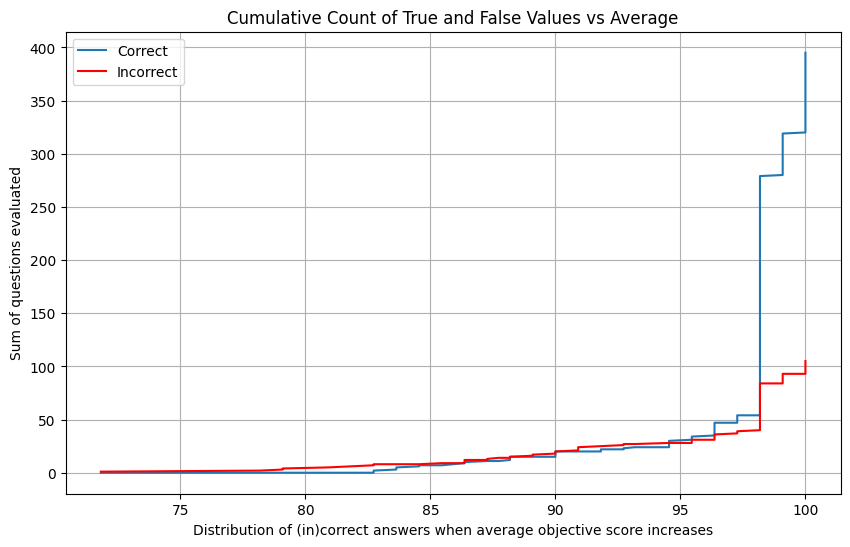

In [27]:
data = scores_with_indicator
data = [(t[0], False if t[1] is None else t[1]) for t in data]
df = pd.DataFrame([t[0] for t in data])
df['Indicator'] = [t[1] for t in data]
df_for_reg = copy.deepcopy(df)
# Sort DataFrame based on the 'Average' column from low to high
df = df.sort_values(by='average')
df['Cumulative Count'] = df['Indicator'].cumsum()
df['Cumulative Count False'] = (~df['Indicator']).cumsum()

# Plot graph with 'Average' as x-axis and 'Cumulative Count' and 'Cumulative Count False' as y-axis
plt.figure(figsize=(10, 6))
plt.plot(df['average'], df['Cumulative Count'], label='Correct')
plt.plot(df['average'], df['Cumulative Count False'], label='Incorrect', color='red')
plt.xlabel('Distribution of (in)correct answers when average objective score increases')
plt.ylabel('Sum of questions evaluated')
plt.title('Cumulative Count of True and False Values vs Average')
plt.grid(True)
plt.legend()
plt.show()

In [155]:
X = df_for_reg.drop('Indicator', axis=1)  # Features
y = df_for_reg['Indicator']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.79


In [157]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X, y)

y_pred = classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.806


In [158]:
# Get the coefficients and intercept
coefficients = classifier.coef_
intercept = classifier.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[-0.03132124  0.00437515  0.00325933 -0.04750339  0.01897088  0.06438299
   0.04457324  0.00299101 -0.03515297  0.04234187  0.03498207 -0.00370211
   0.00926354]]
Intercept: [-9.00329179]


In [159]:
#check feature selection
from sklearn.feature_selection import SelectFromModel

# Perform feature selection using L1 regularization
selector = SelectFromModel(classifier, threshold=None)
selector.fit(X_train, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get selected feature names
selected_feature_names = X_train.columns[selected_feature_indices]

# Print selected feature names
print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['obj_4', 'obj_5', 'obj_6', 'obj_10', 'lowest'], dtype='object')


In [160]:
# Assuming you have already obtained the selected_feature_names list
selected_feature_names = ['obj_1', 'obj_3', 'obj_7', 'obj_10']

# Filter the original dataset to include only the selected features
filtered_X = X[selected_feature_names]

In [161]:
X_train, X_test, y_train, y_test = train_test_split(filtered_X, y, test_size=0.2, random_state=42)

In [162]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.78


In [165]:
classifier = LogisticRegression(max_iter=10000)
classifier.fit(filtered_X, y)

y_pred = classifier.predict(filtered_X)
accuracy = accuracy_score(y, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.798


## Correlations

In [28]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlation values with the 'Indicator' variable
indicator_correlation = correlation_matrix['Indicator']

print(indicator_correlation)

obj_1                     0.171472
obj_2                     0.238102
obj_3                     0.067392
obj_4                     0.244681
obj_5                     0.121717
obj_6                     0.241012
obj_7                     0.204262
obj_8                     0.264401
obj_9                     0.025495
obj_10                    0.206819
obj_11                    0.209433
lowest                    0.263987
average                   0.274466
Indicator                 1.000000
Cumulative Count          0.193491
Cumulative Count False    0.219420
Name: Indicator, dtype: float64
